<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-285 - Computación Científica </h1>
    <h2> Floating Point Arithmetic </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.18 </h2>
</center>


## Table of Contents
* [Introduction](#intro)
* [The nature of floating point numbers](#nature)
* [Visualization of floating point numbers](#visualization)
* [What is the first integer that is not representable in double precision?](#firstinteger)
* [Loss of significance](#loss)
* [Loss of significance in funcion evaluation](#func)
* [Another analysis (example from textbook)](#another)
* [Acknowledgements](#acknowledgements)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<div id='intro' />

## Introduction

Hello! This notebook is an introduction to how our computers handle the representation of real numbers using double-presicion floating-point format. To understand the contents of this notebook you should have at least a basic notion of how binary numbers work.

The aforementioned format occupies 64 bits which are divided as follows:

* 1 bit for the sign
* 11 bits for the exponent
* 52 bits for the mantissa

This means that the very next representable number after $1$ is $1 + 2^{-52}$, and their difference, $2^{-52}$, is the $\epsilon_{mach}$.

Additionally, if you'd like to quickly go from a base-2 integer to a base-10 integer and viceversa, Python has some functions that can help you with that.

In [72]:
int('0b11', 2)

3

In [73]:
bin(9)

'0b1001'

In [74]:
bin(2**53)

'0b100000000000000000000000000000000000000000000000000000'

<div id='nature' />

## The nature of floating point numbers

As we know until now, float representations of real numbers are just a finite and bounded representation of them. But another interesting thing, is that these floating numbers are distributed across the real numbers. 

To see that, it's really important to keep in mind the following property:

\begin{equation} \left|\frac{\text{fl}(x)-x}{x}\right| \leq \frac{1}{2} \epsilon_{\text{mach}} \end{equation}

where $\text{fl}(x)$ means the float representation of $x \in \mathbb{R}$. What it says is that **the relative error in representing any non-zero real number x, is bounded by a quantity that depends on the system representation** ($\epsilon_{\text{mach}}$).

Maybe now you're thinking: what relationship does this have with the distribution of floating point numbers? So if we rewrite the previous property like this:

\begin{equation} |\text{fl}(x)-x| \leq \frac{1}{2} \epsilon_{\text{mach}} |x| \end{equation}

it's clearer: **The absolute error (distance) between a real number and its floating point representation is proportional to the real number's magnitude.**

Intuitively speaking, if the representation error of a number increases as its magnitude increases, then it's quite natural that **the distance between a floating point number and the next representable floating point number will increase as the magnitude of such number increases (and conversely)**. Could you prove that?  For now we will prove it experimentally.

We will use a library named **bitstring** to handle different number representations. You can install it with:
```
pip install bitstring
```

In [75]:
import bitstring as bs

The next two functions are self-explanatory:

1. `next_float(f)` computes the next representable float number.
2. `gap(f)` computes the difference between $f$ and the next representable float number

In [83]:
def next_float(f):
    #packing double-precision foat
    b = bs.pack('>d', f)
    
    #extracting mantisa as unsigned int and adding up 1.
    # There are two cases, (1) if the bits of the mantissa are all 1,
    # (2) all the other cases.
    m = b[12:].uint
    if m==4503599627370495:
        # Case (1)
        m=0
        b[12:] = m
        exp=b[1:12].uint
        exp +=1
        b[1:12] = exp
        
    else:
        # Case (2)
        m += 1
        # putting the result in his place
        b[12:] = m
    
    return b.float

def gap(f):
    next_f = next_float(f)
    return next_f - f

So if we compute `gap(1)` we should get the epsilon machine number. Let's try it:

In [84]:
gap(1)

2.220446049250313e-16

In [89]:
# This is the case (1) mentioned in the definition of next_float.
next_float(2-gap(1))

2.0

In order to prove our hypotesis, we will create an array of values: $[2^{-5},...,2^{60}]$ and compute their corresponding epsilon.

In [101]:
values = np.array([2**i for i in range(-5,60)]).astype(float)

# Corresponding gaps:
# The Numpy function "vectorize" is very useful to be use one wants to apply
# a scalar function to each element of an array.
vgap = np.vectorize(gap)
gaps = vgap(values)

We include now a comparison between a linear scale plot and a loglog scale plot. Which one is more useful here?

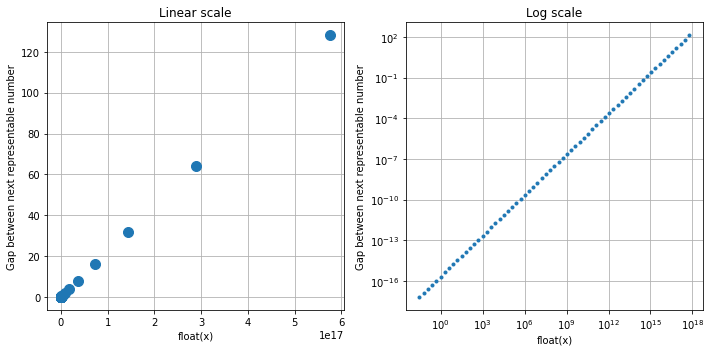

In [102]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(values, gaps,'.',markersize=20)
plt.xlabel('float(x)')
plt.ylabel('Gap between next representable number')
plt.title('Linear scale')
plt.grid(True)

plt.subplot(122)
plt.loglog(values, gaps,'.')
plt.xlabel('float(x)')
plt.ylabel('Gap between next representable number')
plt.title('Log scale')
plt.grid(True)

fig.tight_layout()
plt.show()

As you can see, the hypotesis was right. In other words: Floating point numbers are not linearly distributed across the real numbers, and the distance between them is proportional to their magnitude. **Tiny numbers (~ 0) are closer between each other than larger numbers are.**

Moreover, we can conclude that for large value the gap is larger that $1$, which means that there will be integers that will not be stored.

<div id='visualization' />

## Visualization of floating point numbers

With the help of `bitstring` library we could write a function to visualize floating point numbers in his binary representation 

In [103]:
def to_binary(f):
    b = bs.pack('>d', f)
    b = b.bin
    #show sign + exponent + mantisa
    print(b[0]+' '+b[1:12]+ ' '+b[12:])

Let's see some intereseting examples

In [104]:
to_binary(1.)

0 01111111111 0000000000000000000000000000000000000000000000000000


In [105]:
int('0b01111111111', 2)

1023

In [106]:
to_binary(1.+epsilon(1.))

0 01111111111 0000000000000000000000000000000000000000000000000001


In [107]:
to_binary(+0.)

0 00000000000 0000000000000000000000000000000000000000000000000000


In [108]:
to_binary(-0.)

1 00000000000 0000000000000000000000000000000000000000000000000000


In [109]:
to_binary(np.inf)

0 11111111111 0000000000000000000000000000000000000000000000000000


In [110]:
to_binary(-np.inf)

1 11111111111 0000000000000000000000000000000000000000000000000000


In [111]:
to_binary(np.nan)

0 11111111111 1000000000000000000000000000000000000000000000000000


In [112]:
to_binary(-np.nan)

1 11111111111 1000000000000000000000000000000000000000000000000000


In [113]:
to_binary(2.**-1074)

0 00000000000 0000000000000000000000000000000000000000000000000001


In [114]:
print(2.**-1074)

5e-324


In [115]:
to_binary(2.**-1075)

0 00000000000 0000000000000000000000000000000000000000000000000000


In [116]:
print(2.**-1075)

0.0


In [117]:
to_binary(9.4)

0 10000000010 0010110011001100110011001100110011001100110011001101


<div id='firstinteger' />

## What is the first integer that is not representable in double precision?

Recall that $\epsilon_{\text{mach}}=2^{-52}$ in double precision.

In [118]:
to_binary(1)
to_binary(1+2**-52)

0 01111111111 0000000000000000000000000000000000000000000000000000
0 01111111111 0000000000000000000000000000000000000000000000000001


This means that if we want to store any number in the interval $[1,1+\epsilon_{\text{mach}}]$, only the numbers $1$ and $1+\epsilon_{\text{mach}}$ will be stored. For example, compare the exponent and the mantissa in the previous cell with the following outputs:

In [ ]:
for i in np.arange(1,11):
    to_binary(1+i*2**-55)

Now, we can scale this difference such that the scaling factor multiplied but $\epsilon_{\text{mach}}$ is one. The factor will be $2^{52}$. This means $2^{52}\,\epsilon_{\text{mach}}=1$. Repeating the same example as before but with the scaling factor we obtain:

In [ ]:
for i in np.arange(11):
    to_binary((1+i*2**-55)*2**52)

Which means we can only store exactly the numbers:

In [ ]:
to_binary(2**52)
to_binary(2**52+1)

This means, the distance now from $2^{52}$ and the following number representable is $1$ !!!! So, what would happend if I can to store $2^{53}+1$?

In [ ]:
to_binary(2**53)
to_binary(2**53+1)

I can't stored the **Integer** $2^{53}+1$! Thus, the first integer not representable is $2^{53}+1$.

<div id='loss' />

## Loss of significance

As we mentioned, there's a small leap between 1 and the next representable number, which means that if you want to represent a number between those two, you won't be able to do so; that number is nonexistent as it is for the computer, so it'll have to round it to a representable number before storing it in memory.

In [ ]:
a = 1.
b = 2.**(-52) #emach
result_1 = a + b     # arithmetic result is 1.0000000000000002220446049250313080847263336181640625
result_1b = result_1-1.0
print("{0:.1000}".format(result_1))
print(result_1b)
print(b)

In [ ]:
c = 2.**(-53)
result_2 = a + c     # arithmetic result is 1.00000000000000011102230246251565404236316680908203125
np.set_printoptions(precision=16)
print("{0:.1000}".format(result_2))
print(result_2-a)

In [ ]:
to_binary(result_2)
to_binary(result_2-a)

In [ ]:
d = 2.**(-53) + 2.**(-54)

result_3 = a + d     # arithmetic result is 1.000000000000000166533453693773481063544750213623046875
print("{0:.1000}".format(result_3))
to_binary(result_3)
to_binary(d)

As you can see, if you try to save a number between $1$ and $1 + \epsilon _{mach}$, it will have to be rounded (according to some criteria) to a representable number before being stored, thus creating a difference between the <i>real</i> number and the <i>stored</i> number. This situation is an example of loss of significance.

Does that mean that the "leap" between representable numbers is <i>always</i> going to be $\epsilon _{mach}$? Of course not! Some numbers will require smaller leaps, and some others will require bigger leaps. 

In any interval of the form $[2^n,2^{n+1}]$ for $n\in \mathbb{Z}$ and representables, is constant. For example, all the numbers between $2^{-1}$ and $2^0$ (but excluding $2^0$) have a distance of $\epsilon _{mach}/2$ between them. All the numbers between $2^0$ and $2^1$ (excluding $2^1$) have a distance of $\epsilon _{mach}$ between them. Those between $2^1$ and $2^2$ (not including $2^2$) have a distance of $2\,\epsilon _{mach}$ between them, and so on and so forth.

In [ ]:
e = 2.**(-1)
f = b/2. # emach/2

result_4 = e + f     # 0.50000000000000011102230246251565404236316680908203125
print("{0:.1000}".format(result_4))

result_5 = e + b     # 0.5000000000000002220446049250313080847263336181640625
print("{0:.1000}".format(result_5))

In [ ]:
g = b/4.

result_5 = e + g     # 0.500000000000000055511151231257827021181583404541015625
print("{0:.1000}".format(result_5))

We'll let the students find some representable numbers and some non-representable numbers. It's important to note that loss significance can occur in many more operations and functions other that the simple addition of two numbers.

In [ ]:
num_1 = a
num_2 = b
result = a + b
print("{0:.1000}".format(result))

<div id='func' />

## Loss of significance in function evaluation

Loss of Significance is present too in the representation of **functions**. A classical example (which you can see in the guide book), is the next function: 

\begin{equation}f(x)= \frac{1 - \cos x}{\sin^{2}x} \end{equation}

Applying trigonometric identities, we can obtain the 'equivalent' function:

\begin{equation}f(x)= \frac{1}{1 + \cos x} \end{equation}


Both of these functions are apparently equals. Nevertheless, its graphics say to us another thing when $x$ is equal to zero. 

In [ ]:
x = np.arange(-10,10,0.1)
y = (1-np.cos(x))/(np.sin(x)**2)
plt.figure()
plt.plot(x,y,'.')
plt.grid(True)
plt.show()

In [ ]:
x = np.arange(-10,10,0.1)
y = 1/(1+np.cos(x))
plt.figure()
plt.plot(x,y,'.')
plt.grid(True)
plt.show()

In [ ]:
x = np.arange(-1,1,0.01)
y = (1-np.cos(x))/np.sin(x)**2
plt.figure()
plt.plot(x,y,'.',markersize=10)
plt.grid(True)
plt.show()

In [ ]:
y = 1/(1+np.cos(x))
plt.figure()
plt.plot(x,y,'.',markersize=10)
plt.grid(True)
plt.show()

This happens because when $x$ is equal to zero, the first function has an indetermination, but previously, the computer makes a subtraction between numbers that are almost equals. This generates a loss of significance, turning the expression close to this point to be zero. However, modifying this expression to make the second function, eliminates this substraction, fixing the error in its calculation when $x=0$.

In conclusion, for us, two representations of a function can be equals, but for the computer they can be different!

<div id='another' />

## Another analysis (example from textbook)

In [ ]:
f1 = lambda x: (1.-np.cos(x))/(np.sin(x)**2)
f2 = lambda x: 1./(1+np.cos(x))
f3 = lambda x: (1.-np.cos(x))
f4 = lambda x: (np.sin(x)**2)
x = np.logspace(-19,0,20)[-1:0:-1]
o1 = f1(x)
o2 = f2(x)
o3 = f3(x)
o4 = f4(x)

print("x,            f1(x),        f2(x),        f3(x),                       f4(x)")
for i in np.arange(len(x)):
    print("%1.10f, %1.10f, %1.10f, %1.25f, %1.25f" % (x[i],o1[i],o2[i],o3[i],o4[i]))

## Libraries
### Please make sure you make all of them your BFF!!

* Numpy - IEEE 754 Floating Point Special Values: https://docs.scipy.org/doc/numpy-1.10.0/user/misc.html
* Matplotlib: http://matplotlib.org/examples/pylab_examples/simple_plot.html
* Nice Trick: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

<div id='acknowledgements' />

# Acknowledgements
* _Material originally created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. v.1.1. DI UTFSM. March 2016._
* _Update April 2020 - v1.14 - C.Torres_ : Fixing some issues.
* _Update April 2020 - v1.15 - C.Torres_ : Adding subplot.
* _Update April 2020 - v1.16 - C.Torres_ : Adding value of numerator and denominator in example of f1 = lambda x: (1.-np.cos(x))/(np.sin(x)** 2).
* _Update April 2020 - v1.17 - C.Torres_ : Adding section "What is the first integer that is not representable in double precision?"
* _Update April 2021 - v1.18 - C.Torres_ : Function "epsilon" renamed to function "gap" and fixed special case for function "next_float".